In [2]:
import pandas as pd
import os
import logging
from io import TextIOWrapper
import re

from pyteomics.mztab import MzTab
from pyteomics import mgf
from psm_utils import PSM, PSMList, Peptidoform
from tqdm import tqdm

from psm_utils.peptidoform import PeptidoformException

from denovo_utils.parsers.constants import MODIFICATION_MAPPING_TO_SPECTRALIS

from glob import glob

from denovo_utils.parsers.converters.utils import parse_peptidoform

tqdm.pandas()

Modification already exists in ModificationsDB. Skipping.


In [4]:
filename = "LFQ_TTOF6600_DDA_Human_01"
mgf_file = mgf.read(f"/home/samva/Doctorate/data_directory/PXD028735/mgf/TTOF6600/original/{filename}.mgf")

In [5]:
import re


def parse_title(spectrum: dict):
    title_pattern = r"controllerType=\d+ controllerNumber=\d+ scan=(\d+)"
    try:
        title = spectrum["params"]["title"]
    except KeyError:
        return False, False
    
    match = re.search(title_pattern, title)
    if match:
        title_id = match.group(0)
        scan_number = match.group(1)
        return title_id, scan_number
    else:
        return False, False

def parse_charge(spectrum: dict):

    try:
        charge = spectrum["params"]["charge"]
    except KeyError:
        return False
    
    if len(charge)>1:
        logging.warning(f"{spectrum['params']['title']}: Has multiple charges ({charge})")
    return int(charge[0])

def parse_pepmass(spectrum: dict, silence_warning=True):

    try:
        pepmass = spectrum["params"]["pepmass"]
        if len(pepmass)>1 and not silence_warning:
            logging.warning(f"{spectrum['params']['title']}: Pepmass field holds multiple values. ({pepmass})")
        return pepmass[0]
    except KeyError:
        raise Exception("No pepmass field in the precursor info of MGF spectrum.")

def check_required_fields(spectrum: dict):

    start_new_index = False

    # Check title field
    title_id, _ = parse_title(spectrum)
    if title_id == False:
        start_new_index = True
    
    # Check charge field
    _ = parse_charge(spectrum)

    # Check pepmass
    _ = parse_pepmass(spectrum, silence_warning=False)

    return start_new_index

In [7]:
for i, spec in enumerate(mgf_file):
    mz_array = spec["m/z array"]

TypeError: 'NoneType' object is not subscriptable

In [12]:
mgf_file[55659]

In [9]:
spec

In [8]:
i

55658

In [55]:
def reformat_mgf(
        path_mgf,
        output_dir="",
        min_peak_length=15,
        max_charge=8
    ):

    mgf_file = mgf.read(path_mgf)
    filename = os.path.basename(path_mgf)
    logging.info(f"\n\nParsing {filename}")

    total_spectra = len(mgf_file)
    start_new_index = check_required_fields(spectrum=mgf_file[0])

    spectrum_list = []

    skipped_missing_charge = 0
    skipped_above_max_charge = 0
    skipped_by_peak_length = 0

    for i, spectrum in enumerate(mgf_file):
        
        if len(spectrum["m/z array"]) < min_peak_length:
            skipped_by_peak_length += 1
            continue

        if start_new_index:
            title, scan_id = f"controllerType=0 controllerNumber=1 scan={i}", i
        else:
            title, scan_id = parse_title(spectrum=spectrum)
        
        charge = parse_charge(spectrum=spectrum)
        if charge==False:
            skipped_missing_charge += 1
            continue

        if charge > max_charge:
            skipped_above_max_charge += 1
            continue

        pepmass = parse_pepmass(spectrum=spectrum)
        rtinseconds = spectrum["params"]["rtinseconds"]
            
        params = {
            "title": title,
            "pepmass": pepmass,
            "rtinseconds": rtinseconds,
            "charge": str(charge)+"+",
            "scans": scan_id,
        }
        spectrum["params"] = params
        spectrum_list.append(spectrum)

    if spectrum_list == []:
        logging.warning(f"{filename}: No spectra left after precursor info validation and filtering.")

    logging.info(
        f"\nTotal spectra: {total_spectra}; After filtering: {len(spectrum_list)}\n\t"
        f"Filtered spectra: {total_spectra-len(spectrum_list)}\n\t" \
        f"Peaks below{min_peak_length}: {skipped_by_peak_length}\n\t" \
        f"No charge field: {skipped_missing_charge}\n\t" \
        f"Above max charge ({max_charge}): {skipped_above_max_charge}"
    )

    if (skipped_missing_charge+skipped_by_peak_length) == total_spectra:
        raise Exception("Use a charge predictor for annotation! All MGFs have missing charge field.")

    mgf.write(
        spectra=spectrum_list,
        output=os.path.join(output_dir, filename),
        header=mgf_file.header
    )

In [59]:
for p in glob("/home/samva/Doctorate/data_directory/tests/mgf/*.mgf"):
    print(p)
    reformat_mgf(
        path_mgf=p,
        output_dir="/home/samva/Doctorate/data_directory/tests/mgf_reformatted",
        min_peak_length=15,
        max_charge=8
    )

/home/samva/Doctorate/data_directory/tests/mgf/test2.mgf
/home/samva/Doctorate/data_directory/tests/mgf/test3.mgf


Exception: Use a charge predictor for annotation! All MGFs have missing charge field.

---

In [2]:
casanovo = {  "G": 57.021464,
  "A": 71.037114,
  "S": 87.032028,
  "P": 97.052764,
  "V": 99.068414,
  "T": 101.047670,
  "C+57.021": 160.030649, # 103.009185 + 57.021464,
  "L": 113.084064,
  "I": 113.084064,
  "N": 114.042927,
  "D": 115.026943,
  "Q": 128.058578,
  "K": 128.094963,
  "E": 129.042593,
  "M": 131.040485,
  "H": 137.058912,
  "F": 147.068414,
  "R": 156.101111,
  "Y": 163.063329,
  "W": 186.079313,
  # Amino acid modifications.,
  "M+15.995": 147.035400 ,  # Met oxidation:   131.040485 + 15.994915,
  "N+0.984": 115.026943 ,    # Asn deamidation: 114.042927 +  0.984016,
  "Q+0.984": 129.042594 ,    # Gln deamidation: 128.058578 +  0.984016
  # N-terminal modifications.,
  "+42.011": 42.010565 ,     # Acetylation,
  "+43.006": 43.005814    ,  # Carbamylation,
  "-17.027": -17.026549   ,  # NH3 loss,
  "+43.006-17.027": 25.980265    ,  # Carbamylation and NH3 loss
}

In [4]:
idx2amino = {0: '<pad>',1: '<bos>', 2: '<eos>',
             3: 'A', 4: 'C', 5: 'D', 6: 'E', 7: 'F',
             8: 'G', 9: 'H', 10: 'I', 11: 'K', 12: 'L',
             13: 'M', 14: 'N', 15: 'P', 16: 'Q', 17: 'R',
             18: 'S', 19: 'T', 20: 'V', 21: 'W', 22: 'Y',
             23: 'm', 24: 'n', 25: 'q', 26: 's', 27: 't', 28: 'y'}


# High: D = n, E = q, L = I
# Low: K = Q (0.4), F = m (0.3)
idx2mass = {0: 0.00, 1: 0.00, 2: 0.00,
             3: 71.037, 4: 160.031, 5: 115.027, 6: 129.043, 7: 147.068,
             8: 57.021, 9: 137.059, 10: 113.084, 11: 128.095, 12: 113.084,
             13: 131.040, 14: 114.043, 15: 97.053, 16: 128.059, 17: 156.101,
             18: 87.032, 19: 101.048, 20: 99.068, 21: 186.079, 22: 163.063,
             23: 147.035, 24: 115.027, 25: 129.043, 26: 166.998, 27: 181.014, 28:243.030}

In [5]:
for k in idx2amino.keys():
    print("{}\n({})".format(idx2amino[k], idx2mass[k]))

<pad>
(0.0)
<bos>
(0.0)
<eos>
(0.0)
A
(71.037)
C
(160.031)
D
(115.027)
E
(129.043)
F
(147.068)
G
(57.021)
H
(137.059)
I
(113.084)
K
(128.095)
L
(113.084)
M
(131.04)
N
(114.043)
P
(97.053)
Q
(128.059)
R
(156.101)
S
(87.032)
T
(101.048)
V
(99.068)
W
(186.079)
Y
(163.063)
m
(147.035)
n
(115.027)
q
(129.043)
s
(166.998)
t
(181.014)
y
(243.03)


In [3]:
for k, v in casanovo.items():
    print("{}: {}".format(k, v))

G: 57.021464
A: 71.037114
S: 87.032028
P: 97.052764
V: 99.068414
T: 101.04767
C+57.021: 160.030649
L: 113.084064
I: 113.084064
N: 114.042927
D: 115.026943
Q: 128.058578
K: 128.094963
E: 129.042593
M: 131.040485
H: 137.058912
F: 147.068414
R: 156.101111
Y: 163.063329
W: 186.079313
M+15.995: 147.0354
N+0.984: 115.026943
Q+0.984: 129.042594
+42.011: 42.010565
+43.006: 43.005814
-17.027: -17.026549
+43.006-17.027: 25.980265


In [4]:
root_novor = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/*.novor.csv"
root_mgf = "/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/*.mgf"

result_mgf_pair = {}

for mgf_path in glob(root_mgf):
    mgf_filename = os.path.splitext(os.path.basename(mgf_path))[0]
    for novob_path in glob(root_novor):
        novob_filename = os.path.basename(novob_path).split(".")[0]
        if mgf_filename==novob_filename:
            result_mgf_pair[mgf_filename] = {
                "mgf": mgf_path,
                "result": novob_path
            }

In [13]:
from denovo_utils.parsers.converters.novob import novob_parser
from denovo_utils.parsers.constants import MODIFICATION_MAPPING

outputs = {}

for result_mgf in result_mgf_pair.values():
    print(result_mgf["result"])
    try:
        psmlist = novob_parser(
            result_path=result_mgf["result"],
            mgf_path=result_mgf["mgf"],
            mapping=MODIFICATION_MAPPING["novob"],
        )
    except KeyError as err:

        outputs[result_mgf["result"]] = err
        continue
    
    outputs[result_mgf["result"]] = len(psmlist)

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F01_Fraction2.tsv


100%|██████████| 77040/77040 [00:03<00:00, 21960.01it/s]


/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F01_Fraction4.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S14_Rep2.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S14_Rep1.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S08.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S03.tsv


100%|██████████| 132500/132500 [00:05<00:00, 22582.22it/s]


/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S14_Rep3.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F07_Fraction4.tsv


100%|██████████| 39490/39490 [00:01<00:00, 23134.98it/s]


/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S11_Fraction3.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S11_Fraction1.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S07.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F07_Fraction3.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F08_Rep2.tsv


100%|██████████| 48802/48802 [00:02<00:00, 20942.00it/s]


/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F07_Fraction2.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F07_Fraction1.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S11_Fraction2.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S11_Fraction4.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F08_Rep1.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F01_Fraction1.tsv


100%|██████████| 8992/8992 [00:00<00:00, 30403.58it/s]


/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F01_Fraction3.tsv
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F08_Rep3.tsv


100%|██████████| 48913/48913 [00:02<00:00, 19282.28it/s]


/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F06.tsv


100%|██████████| 79457/79457 [00:04<00:00, 17805.02it/s]


/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S05.tsv


In [16]:
outputs

{'/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F01_Fraction2.tsv': 76483,
 '/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F01_Fraction4.tsv': 0,
 '/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S14_Rep2.tsv': 0,
 '/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S14_Rep1.tsv': 0,
 '/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S08.tsv': 0,
 '/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S03.tsv': 131605,
 '/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S14_Rep3.tsv': 0,
 '/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/F07_Fraction4.tsv': 38912,
 '/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S11_Fraction3.tsv': 0,
 '/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novob/S11_Fraction1.tsv': KeyError('scans'),
 '/home/samva/Doctorate/da

In [5]:
mgf_path = "/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F01_Fraction1.mgf"
result_novor = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F01_Fraction1.novor.csv"
result_pepnovo = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F01_Fraction1.mgf.out"
result_directag = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/directag/F01_Fraction1.tags"
result_pointnovo = ""

In [21]:
novor_mapping = {
    "C(1)": "C[UNIMOD:4]",
    "M(0)": "M[UNIMOD:35]"
}
peptide = "C(1)C(1)M(0)M(0)M(0)M(0)GM(0)SNGAR"

peptide_parsed = peptide
for k, v in novor_mapping.items():
    if ("-" in v) and (not peptide_parsed.startswith(k)):
        peptide_parsed = peptide_parsed.replace(k, v[:-1])
    else:
        peptide_parsed = peptide_parsed.replace(k, v)

In [23]:
parse_peptidoform(
    peptide="C(1)C(1)M(0)M(0)M(0)M(0)GM(0)SNGAR",
    mapping=novor_mapping,
    max_length=30
)

# 1. Novor

In [24]:
result_path = result_novor
result_path = os.path.splitext(result_path)[0] + ".csv"

mgf_file = pd.DataFrame(pd.DataFrame(mgf.read(mgf_path))["params"].tolist())

In [45]:
def try_peptidoform_conversion(peptide):
    try:
        peptidoform = Peptidoform(peptide)
        return peptidoform
    except PeptidoformException as err:
        return f'ERR: {peptide}'

In [ ]:
from denovo_utils.parsers.converters import DenovoEngineConverter

parser = DenovoEngineConverter.select("casanovo")
parser.parse(
    
)

In [4]:
def parse_peptidoform_(peptide: str, mapping: dict, max_length=30):
    peptide_parsed = peptide
    for k, v in mapping.items():
        if ("-" in v) and (not peptide_parsed.startswith(k)):
            peptide_parsed = peptide_parsed.replace(k, v[:-1])
        else:
            peptide_parsed = peptide_parsed.replace(k, v)

    try:
        peptidoform = Peptidoform(peptide_parsed)
        print(peptidoform)
        if (len(peptidoform) > max_length) or (peptidoform.precursor_charge > 6) or (len(peptidoform) < 2):
            return None
        return peptidoform
    except:
        logging.warning(f"Failed to parse: {peptide}")
        return None

In [96]:
parse_peptidoform_("LLTLAHVMAK", mapping=novor_mapping)

LLTLAHVMAK
LLTLAHVMAK


In [7]:
novor_mapping = {
    "C(1)": "C[UNIMOD:4]",
    "M(0)": "M[UNIMOD:35]"
}

for result_mgf in result_mgf_pair.values():
    
    result_path = result_mgf["result"]
    mgf_path = result_mgf["mgf"]
    run = os.path.basename(result_path)
    print(f"\n{result_path}")

    mgf_file = pd.DataFrame(pd.DataFrame(mgf.read(mgf_path))["params"].tolist()).reset_index()
    result = pd.read_csv(result_path, sep=", ", skiprows=20, engine="python").rename(columns={"scanNum": "scans", "aaScore,": "aaScore"})
    result["scans"] = result["scans"].apply(lambda x: str(x))
    result["index"] = result["# id"].apply(lambda x: int(x)-1)

    print(f"Diff: ({mgf_file.shape[0]-result.shape[0]});\tResult shape ({result.shape}), mgf shape ({mgf_file.shape})")

    # joined_file = result.merge(mgf_file, on="scans")
    joined_file = result.merge(mgf_file, on="index")

    assert len(result) == len(joined_file)
    if len(mgf_file) > len(joined_file):
        logging.info(f"{result_path} for Novor: dropped {len(mgf_file)-len(joined_file)} spectra.")


    joined_file["peptidoform"] = joined_file.apply(
        lambda x: str(x["peptide"] + "/" + str(x["z"])),
        axis=1
    )
    joined_file["peptidoform"] = joined_file["peptidoform"].apply(lambda x: parse_peptidoform(x, mapping=novor_mapping))
    joined_file["precursor_mz"] = joined_file["pepmass"].apply(
        lambda x: x[0]
    )

    joined_file = joined_file.loc[:, [
        "peptidoform",
        "title",
        "score",
        "precursor_mz",
        "rtinseconds",
        "scans_x",
        "err(data-denovo)",
        "ppm(1e6*err/(mz*z))",
        "aaScore"
    ]]
    joined_file = joined_file.dropna(subset=["peptidoform"]).reset_index(drop=True)
    
    psmlist = PSMList(
        psm_list=joined_file.progress_apply(
            lambda x: PSM(
                peptidoform=x["peptidoform"],
                spectrum_id=x["title"],
                run=run,
                score=x["score"],
                precursor_mz=x["precursor_mz"],
                retention_time=x["rtinseconds"],
                source="Novor",
                metadata={
                    "scans": x["scans_x"],
                    "err(data-denovo)": x["err(data-denovo)"],
                    "ppm_error": x["ppm(1e6*err/(mz*z))"],
                    "aaScore": x["aaScore"]
                }
            ),
            axis=1
        ).tolist()
    )
    print(len(psmlist))


/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F01_Fraction2.novor.csv
Diff: (20);	Result shape ((78686, 12)), mgf shape ((78706, 6))


100%|██████████| 78314/78314 [00:03<00:00, 26057.17it/s]


78314

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F01_Fraction4.novor.csv
Diff: (74);	Result shape ((66964, 12)), mgf shape ((67038, 6))


100%|██████████| 65524/65524 [00:04<00:00, 14985.37it/s]


65524

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/S14_Rep2.novor.csv
Diff: (68292);	Result shape ((2344, 12)), mgf shape ((70636, 8))


100%|██████████| 2021/2021 [00:00<00:00, 19841.97it/s]


2021

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/S14_Rep1.novor.csv
Diff: (68228);	Result shape ((2397, 12)), mgf shape ((70625, 8))


100%|██████████| 2086/2086 [00:00<00:00, 23367.16it/s]

2086

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/S08.novor.csv


Diff: (85);	Result shape ((81569, 12)), mgf shape ((81654, 6))


100%|██████████| 81143/81143 [00:03<00:00, 20396.16it/s]


81143

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/S03.novor.csv
Diff: (596);	Result shape ((151967, 12)), mgf shape ((152563, 6))


100%|██████████| 138076/138076 [00:05<00:00, 23612.42it/s]


138076

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/S14_Rep3.novor.csv
Diff: (68960);	Result shape ((2350, 12)), mgf shape ((71310, 8))


100%|██████████| 2020/2020 [00:00<00:00, 39448.78it/s]

2020

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F07_Fraction4.novor.csv


Diff: (267);	Result shape ((40497, 12)), mgf shape ((40764, 6))


100%|██████████| 39867/39867 [00:01<00:00, 25976.88it/s]


39867

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/S11_Fraction3.novor.csv
Diff: (238);	Result shape ((46703, 12)), mgf shape ((46941, 6))


100%|██████████| 44967/44967 [00:02<00:00, 15858.91it/s]


44967

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/S11_Fraction1.novor.csv
Diff: (182);	Result shape ((43265, 12)), mgf shape ((43447, 6))


100%|██████████| 42131/42131 [00:02<00:00, 14148.90it/s]


42131

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/S07.novor.csv
Diff: (305);	Result shape ((46542, 12)), mgf shape ((46847, 6))


100%|██████████| 43686/43686 [00:02<00:00, 15102.72it/s]


43686

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F07_Fraction3.novor.csv
Diff: (209);	Result shape ((44270, 12)), mgf shape ((44479, 6))


100%|██████████| 43375/43375 [00:01<00:00, 25138.00it/s]


43375

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F08_Rep2.novor.csv
Diff: (57763);	Result shape ((2810, 12)), mgf shape ((60573, 8))


100%|██████████| 2332/2332 [00:00<00:00, 22157.65it/s]


2332

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F07_Fraction2.novor.csv
Diff: (313);	Result shape ((38872, 12)), mgf shape ((39185, 6))


100%|██████████| 38102/38102 [00:02<00:00, 19003.01it/s]


38102

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F07_Fraction1.novor.csv
Diff: (267);	Result shape ((36389, 12)), mgf shape ((36656, 6))


100%|██████████| 35875/35875 [00:01<00:00, 28075.72it/s]


35875

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/S11_Fraction2.novor.csv
Diff: (135);	Result shape ((45478, 12)), mgf shape ((45613, 6))


100%|██████████| 43552/43552 [00:02<00:00, 15938.54it/s]


43552

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/S11_Fraction4.novor.csv
Diff: (235);	Result shape ((36940, 12)), mgf shape ((37175, 6))


100%|██████████| 36221/36221 [00:01<00:00, 26495.82it/s]


36221

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F08_Rep1.novor.csv
Diff: (58707);	Result shape ((2789, 12)), mgf shape ((61496, 8))


100%|██████████| 2224/2224 [00:00<00:00, 19874.79it/s]


2224

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F01_Fraction1.novor.csv
Diff: (97);	Result shape ((9060, 12)), mgf shape ((9157, 6))


100%|██████████| 8995/8995 [00:00<00:00, 24748.35it/s]


8995

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F01_Fraction3.novor.csv
Diff: (102);	Result shape ((68704, 12)), mgf shape ((68806, 6))


100%|██████████| 68217/68217 [00:02<00:00, 26882.94it/s]


68217

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F08_Rep3.novor.csv
Diff: (59941);	Result shape ((2599, 12)), mgf shape ((62540, 8))


100%|██████████| 2115/2115 [00:00<00:00, 20277.34it/s]


2115

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/novor/F06.novor.csv


In [113]:
def get_first_scan(scan_string):
    scan_number = []
    for number in scan_string:
        if number.isnumeric():
            scan_number.append(number)
        else:
            break
    return int("".join(scan_number))

In [118]:
mgf_file["scans"].drop_duplicates()

0            316-317
1            318-319
2            320-321
3            322-323
4            324-325
            ...     
70631    75724,75728
70632    75729-75730
70633    75729,75731
70634    75732-75733
70635    75734-75735
Name: scans, Length: 70636, dtype: object

In [129]:
mgf_file.loc[70620]

com                                     Shihumi01b_GA4_01_2831.d
username                                               Demo User
title          Cmpd 71214, +MS2(961.4742), 53.1eV, 142.46min ...
pepmass                                      (961.47419, 8566.0)
rtinseconds                                              8547.38
charge                                                      [2+]
scans                                                75714-75715
Name: 70620, dtype: object

# 2. PepNovo

In [ ]:
>> 0 635 Cmpd 300, +MS2(1246.7633), 65.0eV, 3.71min #636 (SQS 0.012)

In [73]:
pattern = r'>>\s*(\d+)\s+(\d+)\s+(.+?)(?:\s+\((SQS\s+\d+\.\d+)\))?$'
match = re.match(pattern, ">> 0 2476 Cmpd 1346, +MS2(461.7587), 24.2eV, 13.26min #2477")


In [75]:
match.group(4)

In [44]:
if pd.DataFrame([1,2,3]).empty:
    print("hey")

In [39]:
no_solutions = "# No solutions found."
spectrum_error_1 = "# Could not process spectrum..."
spectrum_error_2 = "#Problem reading spectrum..."
too_few_peaks = "# too few peaks..."

spectrum_errors = {
    no_solutions: "no_solution",
    spectrum_error_1: "process_error",
    spectrum_error_2: "reading_error",
    too_few_peaks: "sparse_spectrum"
}

PEPNOVO_COLUMN_MAPPING = {
    "#Index": "index",
    "RnkScr": "score",
    "PnvScr": "score_pepnovo",
    "N-Gap": "n_shift",
    "C-Gap": "c_shift",
    "[M+H]": "mass",
    "Charge": "charge",
    "Sequence": "peptide"
}

PEPNOVO_COLUMNS = [
    'index',
    'score',
    'score_pepnovo',
    'n_shift',
    'c_shift',
    'mass',
    'charge',
    'peptide',
    'index',
    'scans',
    'title',
    'sqs'
]

def parse_metadata_head(input_string) -> tuple:
    # Define the regex pattern
    pattern = r'>>\s*(\d+)\s+(\d+)\s+(.+?)(?:\s+\((SQS\s+\d+\.\d+)\))?$'
    
    # Use re.match to match the pattern
    match = re.match(pattern, input_string)
    
    if match:
        # Extract the matched groups
        number1 = match.group(1)
        number2 = match.group(2)
        random_sequence = match.group(3)
        sqs = match.group(4)
        if not sqs:
            sqs = ""
        return [number1, number2, random_sequence, sqs]
    else:
        raise ValueError(f"The input string does not match the expected format: {input_string}")
    
def parse_header(header):
    header_reformatted = []
    header_list = header.split("\t")
    for col in header_list:
        header_reformatted.append(PEPNOVO_COLUMN_MAPPING[col])
    return header_reformatted

def parse_entry(entry_list: list):
    # Check if a prediction was outputted
    for error_string, error_type in spectrum_errors.items():
        if error_string in entry_list:
            return []
        if not entry_list[1].startswith("#Index"):
            return []
    
    metadata_head = entry_list[0]
    # header = entry_list[1]
    inferences = entry_list[2:]
    
    metadata = parse_metadata_head(metadata_head)
    # column_names = parse_header(header)

    # Only get the top prediction
    top_candidate = inferences[0].split("\t")
    entry = top_candidate + metadata
    return entry[1:]


def pepnovo_to_df(file: TextIOWrapper):

    entries = []
    entry_list = []
    entry = []

    for line in file:
        line=line.strip()
        if line.startswith(">>"):

            if entry_list:
                entry = parse_entry(entry_list)
            if entry:
                entries.append(entry)
            
            entry_list = [line]
            continue

        entry_list.append(line)

    entry = parse_entry(entry_list)
    if entry:
        entries.append(entry)
    return pd.DataFrame(entries, columns=PEPNOVO_COLUMNS[1:])


In [40]:
from glob import glob
import os

mapping_pepnovo = {
    "M+16": "M[UNIMOD:35]",
    "C": "C[UNIMOD:4]"
}

root_novor = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/*.mgf.out"
root_mgf = "/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/*.mgf"

result_mgf_pair = {}

for mgf_path in glob(root_mgf):
    mgf_filename = os.path.splitext(os.path.basename(mgf_path))[0]
    for novob_path in glob(root_novor):
        novob_filename = os.path.basename(novob_path).split(".")[0]
        if mgf_filename==novob_filename:
            result_mgf_pair[mgf_filename] = {
                "mgf": mgf_path,
                "result": novob_path
            }

for result_mgf in result_mgf_pair.values():
    result_path = result_mgf["result"]
    mgf_path = result_mgf["mgf"]
    
    print(result_path)
    with open(result_path) as f:

        run = os.path.basename(result_path)
        mgf_file = pd.DataFrame(pd.DataFrame(mgf.read(mgf_path))["params"].tolist())
        # Do not trust MS1-inferred charge state
        # This not matching could be used as a feature?
        _ = mgf_file.pop("charge")
        predictions = pepnovo_to_df(f)

        joined_file = predictions.merge(mgf_file, on="title")
        assert len(predictions)==len(joined_file)

        joined_file["peptidoform"] = joined_file.apply(
            lambda x: x["peptide"] + "/" + str(int(x["charge"])), axis=1
        )
        joined_file["precursor_mz"] = joined_file["pepmass"].apply(
            lambda x: x[0]
        )
        joined_file["peptidoform"] = joined_file["peptidoform"].apply(
            lambda x: parse_peptidoform(x, mapping=mapping_pepnovo, max_length=30)
        )
        joined_file = joined_file.dropna(subset=["peptidoform"]).reset_index(drop=True)

        psm_list = joined_file.progress_apply(
                lambda x: PSM(
                    peptidoform=x["peptidoform"],
                    spectrum_id=x["title"],
                    run=run,
                    score=x["score"],
                    precursor_mz=x["precursor_mz"],
                    retention_time=x["rtinseconds"],
                    source="PepNovo+",
                    metadata={
                        "n_shift": x["n_shift"],
                        "c_shift": x["c_shift"],
                        "score_pepnovo": x["score_pepnovo"],
                        "scans": x["scans_y"]
                    }
                ),
                axis=1
            ).tolist()
        
        psmlist = PSMList(psm_list=psm_list)

    print(len(psmlist))

/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F01_Fraction2.mgf.out


100%|██████████| 58405/58405 [00:04<00:00, 12143.85it/s]


58405
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F01_Fraction4.mgf.out


100%|██████████| 54477/54477 [00:02<00:00, 24241.07it/s]


54477
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/S14_Rep2.mgf.out


100%|██████████| 2430/2430 [00:00<00:00, 26813.43it/s]


2430
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/S14_Rep1.mgf.out


100%|██████████| 2470/2470 [00:00<00:00, 19022.10it/s]


2470
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/S08.mgf.out


100%|██████████| 61139/61139 [00:02<00:00, 24010.74it/s]


61139
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/S03.mgf.out


100%|██████████| 130111/130111 [00:05<00:00, 22212.55it/s]


130111
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/S14_Rep3.mgf.out


100%|██████████| 2441/2441 [00:00<00:00, 21140.66it/s]


2441
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F07_Fraction4.mgf.out


100%|██████████| 32655/32655 [00:02<00:00, 13326.96it/s]


32655
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/S11_Fraction3.mgf.out


100%|██████████| 41529/41529 [00:01<00:00, 24071.25it/s]


41529
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/S11_Fraction1.mgf.out


100%|██████████| 37085/37085 [00:01<00:00, 25853.31it/s]


37085
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/S07.mgf.out


100%|██████████| 30698/30698 [00:01<00:00, 23831.67it/s]


30698
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F07_Fraction3.mgf.out


100%|██████████| 37145/37145 [00:01<00:00, 23465.89it/s]


37145
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F08_Rep2.mgf.out


100%|██████████| 2886/2886 [00:00<00:00, 23770.90it/s]


2886
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F07_Fraction2.mgf.out


100%|██████████| 31328/31328 [00:01<00:00, 25888.43it/s]


31328
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F07_Fraction1.mgf.out


100%|██████████| 27748/27748 [00:01<00:00, 23266.99it/s]


27748
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/S11_Fraction2.mgf.out


100%|██████████| 40535/40535 [00:03<00:00, 12195.67it/s]


40535
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/S11_Fraction4.mgf.out


100%|██████████| 29624/29624 [00:01<00:00, 22769.00it/s]


29624
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F08_Rep1.mgf.out


100%|██████████| 2860/2860 [00:00<00:00, 29447.37it/s]


2860
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F01_Fraction1.mgf.out


100%|██████████| 5370/5370 [00:00<00:00, 25187.47it/s]


5370
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F01_Fraction3.mgf.out


100%|██████████| 52265/52265 [00:02<00:00, 24921.29it/s]


52265
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F08_Rep3.mgf.out


100%|██████████| 2677/2677 [00:00<00:00, 21623.25it/s]


2677
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/F06.mgf.out


100%|██████████| 67487/67487 [00:04<00:00, 16717.27it/s]


67487
/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pepnovo/S05.mgf.out


100%|██████████| 201050/201050 [00:11<00:00, 17989.32it/s]

201050


In [9]:
joined_file = predictions.merge(mgf_file, on="title")
joined_file["charge_y"] = joined_file["charge_y"].apply(lambda x: str(int(x[0])))

joined_file["charge_unequal"] = joined_file.apply(lambda x: x["charge_x"]!=x["charge_y"], axis=1)

joined_file["score"] = joined_file["score"].apply(lambda x: float(x))
joined_file["score_pepnovo"] = joined_file["score_pepnovo"].apply(lambda x: float(x))

<Axes: xlabel='score_pepnovo', ylabel='Density'>

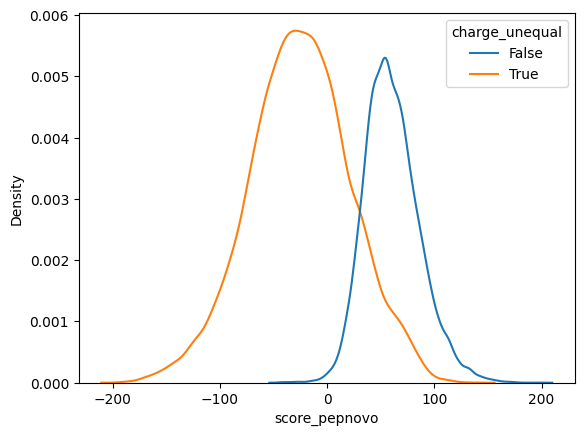

In [10]:
import seaborn as sns


sns.kdeplot(
    joined_file[["score_pepnovo", "charge_unequal"]],
    x="score_pepnovo",
    hue="charge_unequal"
)

<Axes: xlabel='score', ylabel='Density'>

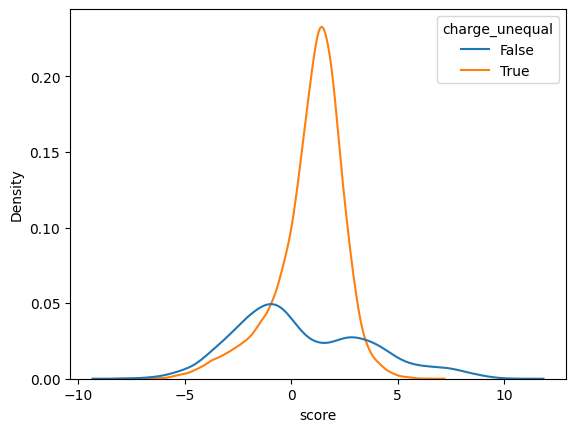

In [12]:
sns.kdeplot(
    joined_file[["score", "charge_unequal"]],
    x="score",
    hue="charge_unequal"
)

# 3. Directag

"Should I skip this?"

# 4. PointNovo

Seems like I can just merge them based on the index of the scans (considering that indeed the mgfs are unfiltered? Maybe I should just redownload the original mgfs and apply it like this.)

In [41]:
pd.read_csv(
    "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pointnovo/F06_features.csv.deepnovo_denovo",
    sep="\t"
)

,feature_id,feature_area,predicted_sequence,predicted_score,predicted_position_score,precursor_mz,precursor_charge,protein_access_id,scan_list_middle,scan_list_original,predicted_score_max
0,1,1.0,NaN,NaN,NaN,439.843872,2.0,NaN,1,1,NaN
1,2,1.0,"F,L,T,E,S,S,S,S,S,S,S,S,S,S,S,S,S,S,L,K,T,K",-2.50,"-0.02,-2.85,-2.86,-2.71,-2.69,-2.69,-2.69,-2.6...",1099.519043,2.0,DENOVO,2,2,-2.50
2,4,1.0,"C(Carbamidomethylation),C(Carbamidomethylation...",-2.50,"-0.07,-3.48,-2.91,-2.89,-2.72,-2.69,-2.72,-2.6...",753.770935,2.0,DENOVO,4,4,-2.50
3,5,1.0,"L,E,S,E,E,E,S,E,S,S,V,L,L,V",-2.54,"-2.69,-2.70,-2.72,-2.70,-2.70,-2.70,-2.72,-2.7...",775.376953,2.0,DENOVO,5,5,-2.54
4,6,1.0,"M(Oxidation),C(Carbamidomethylation),C(Carbami...",-2.86,"-0.02,-3.44,-3.44,-3.44,-3.66,-3.44,-3.44,-2.9...",816.214600,2.0,DENOVO,6,6,-2.86
...,...,...,...,...,...,...,...,...,...,...,...
79267,83182,1.0,"T,S,E,E,E,E,E,E,E,E,E,E,E,E,E,E,D,E,D,C(Carbam...",-2.68,"-2.85,-2.14,-2.48,-2.70,-2.70,-2.70,-2.70,-2.7...",995.313049,3.0,DENOVO,83182,83182,-2.68
79268,83183,1.0,"A,A,G,E,T,G,N,L,A,P,E,K",-1.95,"-0.00,-0.12,-1.94,-2.73,-2.10,-2.30,-2.53,-2.4...",579.292725,2.0,DENOVO,83183,83183,-1.95
79269,83185,1.0,NaN,NaN,NaN,616.463379,2.0,NaN,83185,83185,NaN
79270,83186,1.0,"A,A,L,L,L,L,E,E,E,E,S,S,S,S,P,G,L,E,E,L,M,E,G,G,K",-2.36,"-0.00,-0.40,-2.83,-2.83,-2.83,-2.83,-2.69,-2.6...",873.428894,3.0,DENOVO,83186,83186,-2.36


In [49]:
mgf_F06_og = pd.DataFrame(pd.DataFrame(mgf.read("/home/samva/Doctorate/data_directory/denovo_project/mgf/F06.mgf"))["params"].tolist())

In [45]:
f01_merged = pd.read_csv(
    "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/pointnovo/F01_features.csv.deepnovo_denovo",
    sep="\t"
)

In [46]:
f01_merged

,feature_id,feature_area,predicted_sequence,predicted_score,predicted_position_score,precursor_mz,precursor_charge,protein_access_id,scan_list_middle,scan_list_original,predicted_score_max
0,1,1.0,"V,P,K,P,R,R,L,P,G,L,G,D",-2.05,"-0.00,-0.49,-3.10,-2.86,-2.66,-2.66,-2.67,-1.1...",652.896729,2.0,DENOVO,1,1,-2.05
1,2,1.0,NaN,NaN,NaN,509.907135,2.0,NaN,2,2,NaN
2,3,1.0,"F,S,R,R,R,R,R,S,R",-2.22,"-0.01,-2.90,-2.49,-2.67,-2.67,-2.66,-2.71,-2.3...",638.884766,2.0,DENOVO,3,3,-2.22
3,4,1.0,NaN,NaN,NaN,552.897461,2.0,NaN,4,4,NaN
4,5,1.0,"K,V,L,L,L,G,L,R,S,R",-2.27,"-0.00,-2.12,-2.83,-2.83,-2.83,-2.69,-2.83,-2.5...",577.895569,2.0,DENOVO,5,5,-2.27
...,...,...,...,...,...,...,...,...,...,...,...
218275,223703,1.0,"E,D,E,E,E,D,K,L,F,V,G,V,D,T,L,H,V,K,H",-0.68,"-0.21,-1.03,-0.32,-0.39,-1.19,-2.25,-2.67,-0.7...",747.034800,3.0,DENOVO,223703,223703,-0.68
218276,223704,1.0,"D,E,E,E,G,S,L,D,L,F,V,G,V,D,T,L,H,V,K,H",-0.66,"-0.21,-1.14,-0.18,-0.44,-0.96,-0.61,-2.12,-1.0...",560.527900,4.0,DENOVO,223704,223704,-0.66
218277,223705,1.0,"E,D,E,D,E,E,K,L,F,V,G,V,D,T,L,H,V,H,K",-1.19,"-0.19,-1.07,-0.34,-0.50,-2.50,-2.57,-2.61,-1.7...",747.034400,3.0,DENOVO,223705,223705,-1.19
218278,223706,1.0,"Y,T,E,L,A,S,E,P,D,E,V,G,V,S,E,L,H,V,H,K",-1.59,"-0.01,-2.77,-2.64,-2.92,-2.60,-2.58,-2.60,-2.1...",560.528100,4.0,DENOVO,223706,223706,-1.59


In [2]:
root_1 = "/home/samva/Doctorate/data_directory/denovo_project/mgf"
root_2 = "/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered"

filtered_mgfs = []

for path_1 in glob(os.path.join(root_1, "*.mgf")):
    path_2 = os.path.join(root_2, os.path.basename(path_1))

    mgf_1 = mgf.read(path_1)
    mgf_2 = mgf.read(path_2)

    if len(mgf_1) != len(mgf_2):
        filtered_mgfs.append(os.path.basename(path_1))

In [3]:
filtered_mgfs

['S14_Rep2.mgf',
 'S14_Rep1.mgf',
 'S03.mgf',
 'S14_Rep3.mgf',
 'F08_Rep2.mgf',
 'F08_Rep1.mgf',
 'F08_Rep3.mgf',
 'S05.mgf']

In [52]:
f01_list = []

f01_paths = [
    "/home/samva/Doctorate/data_directory/denovo_project/mgf/F01_Fraction1.mgf",
    "/home/samva/Doctorate/data_directory/denovo_project/mgf/F01_Fraction2.mgf",
    "/home/samva/Doctorate/data_directory/denovo_project/mgf/F01_Fraction3.mgf",
    "/home/samva/Doctorate/data_directory/denovo_project/mgf/F01_Fraction4.mgf"
]

for f01_path in f01_paths:
    f01_file = pd.DataFrame(pd.DataFrame(mgf.read(f01_path))["params"].tolist())
    f01_list.append(f01_file)

f01_mgf_merged = pd.concat(f01_list, ignore_index=True)